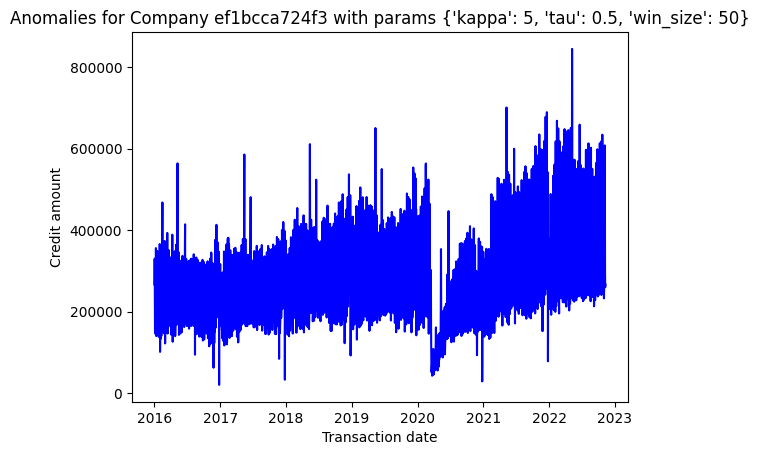

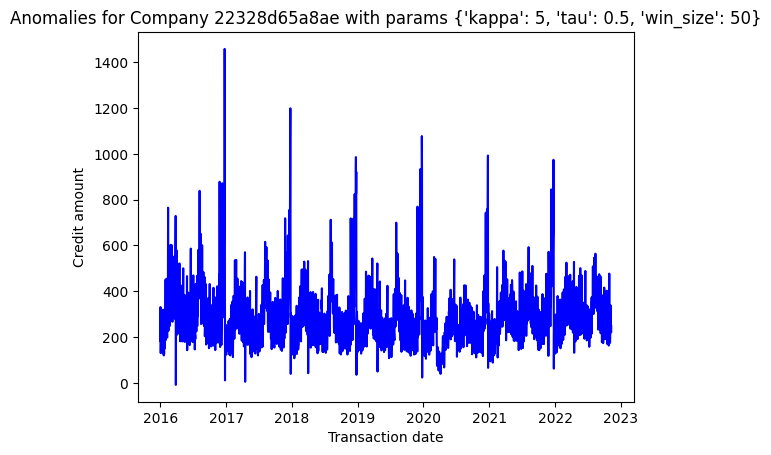

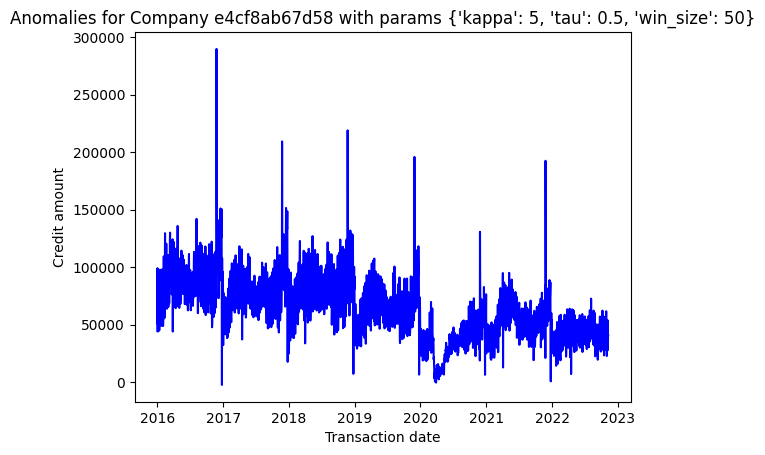

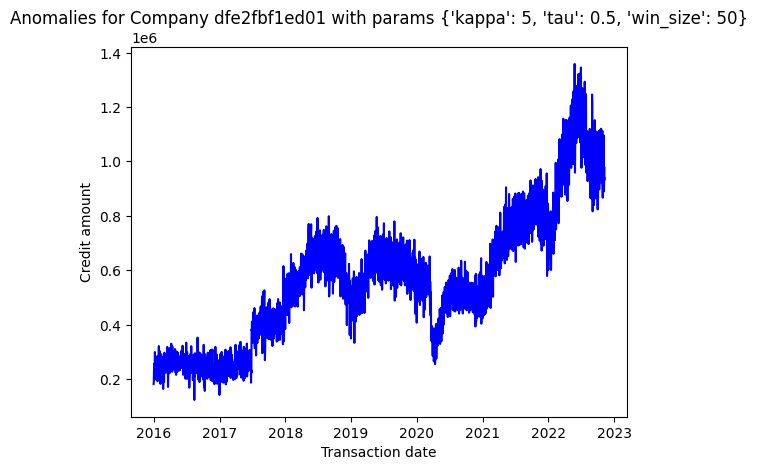

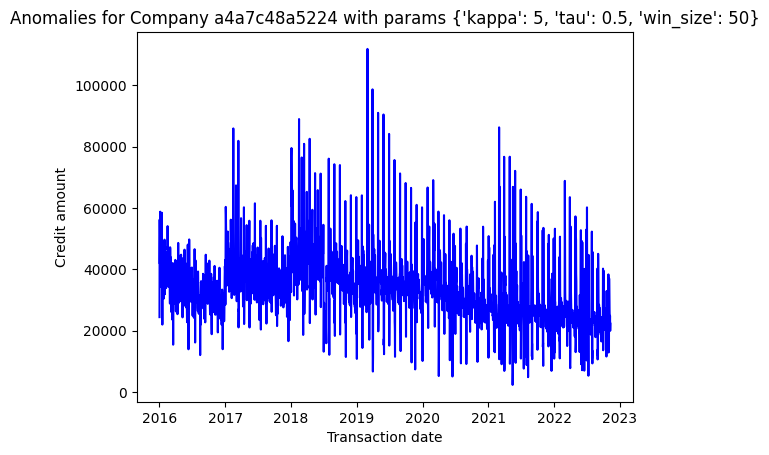

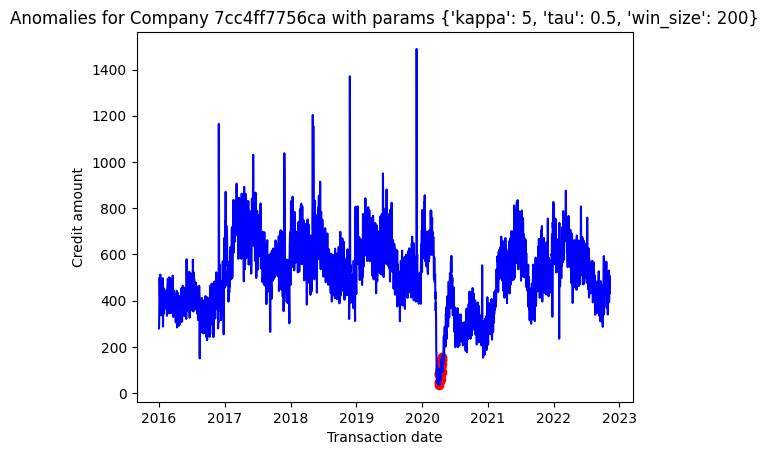

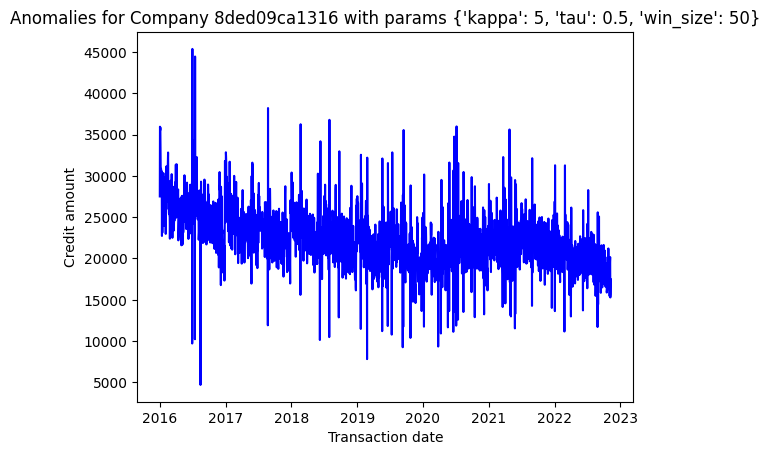

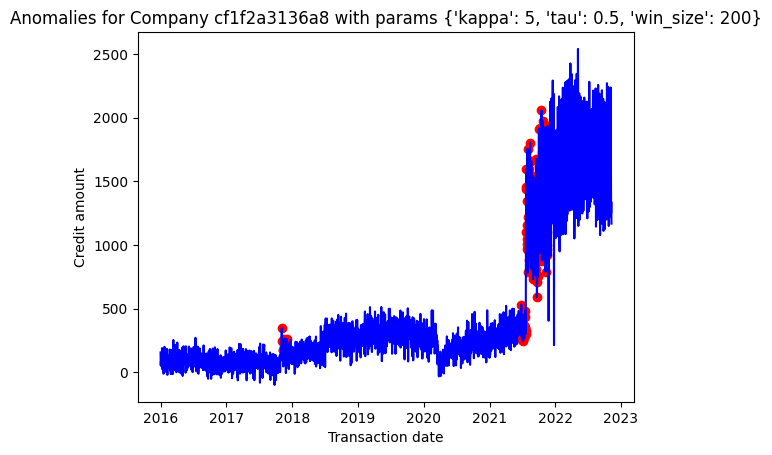

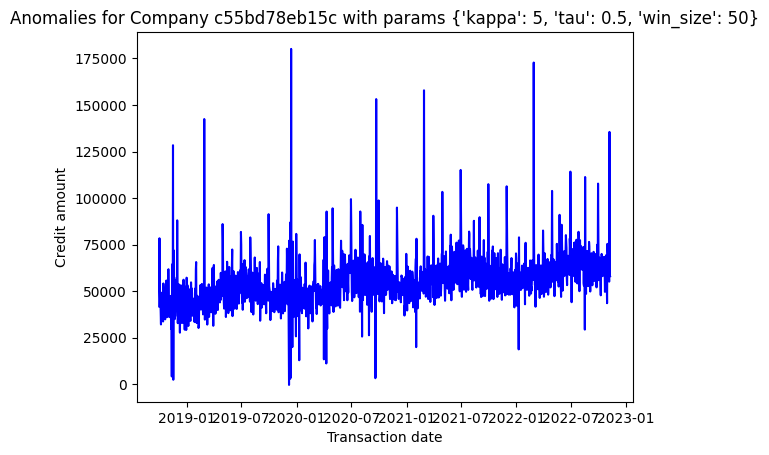

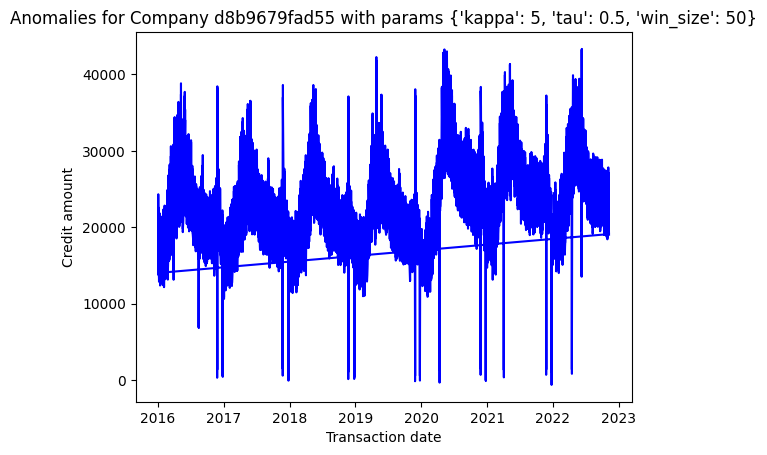

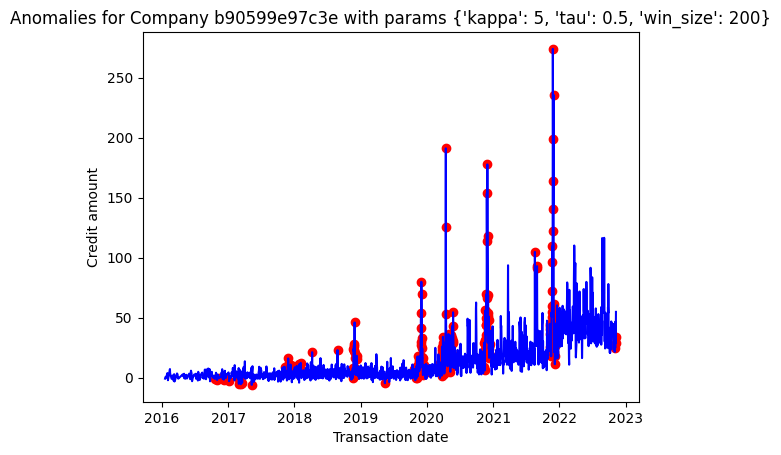

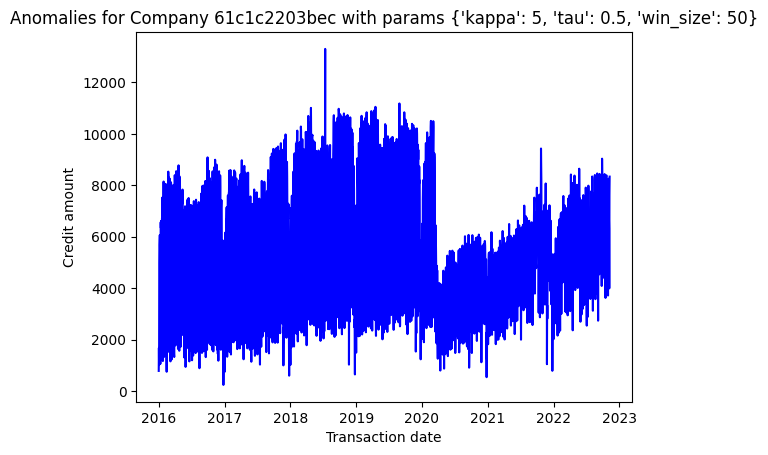

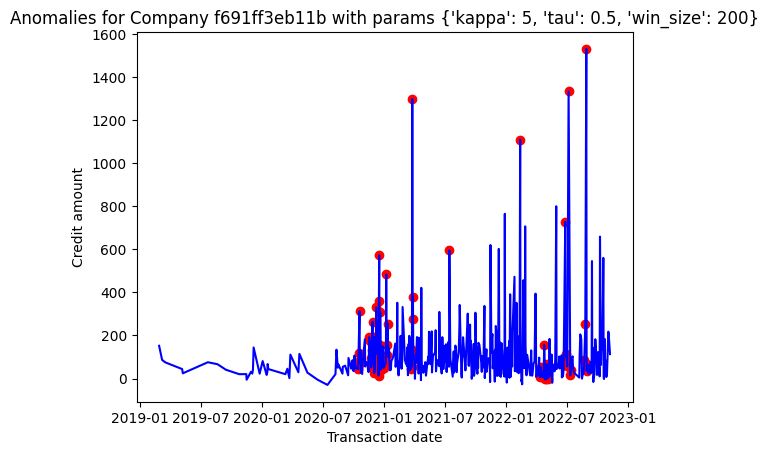

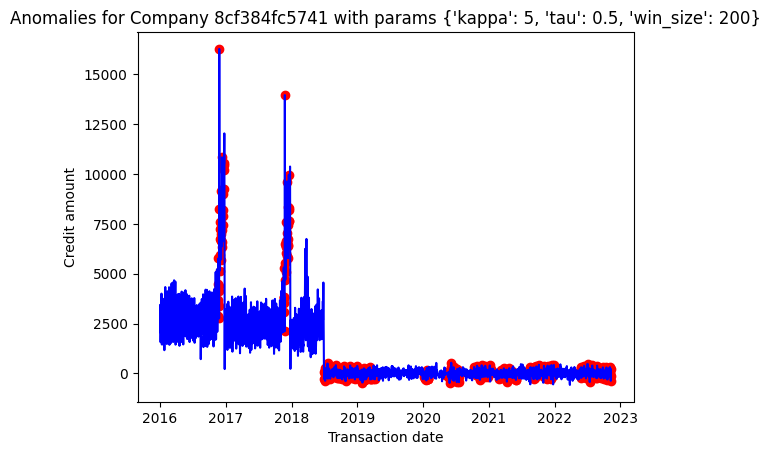

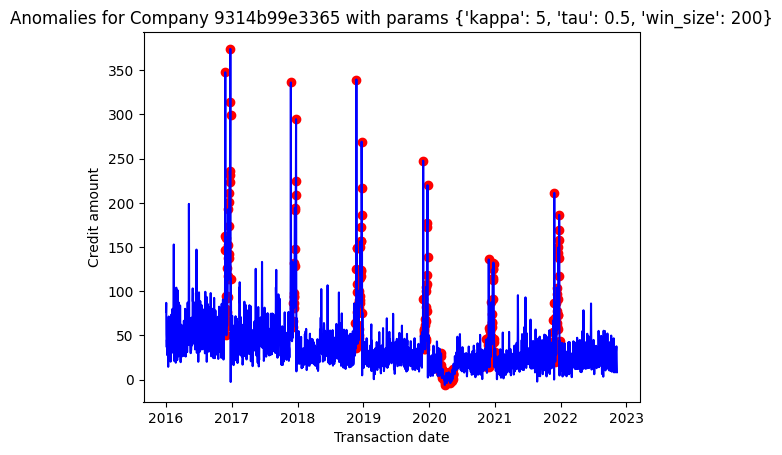

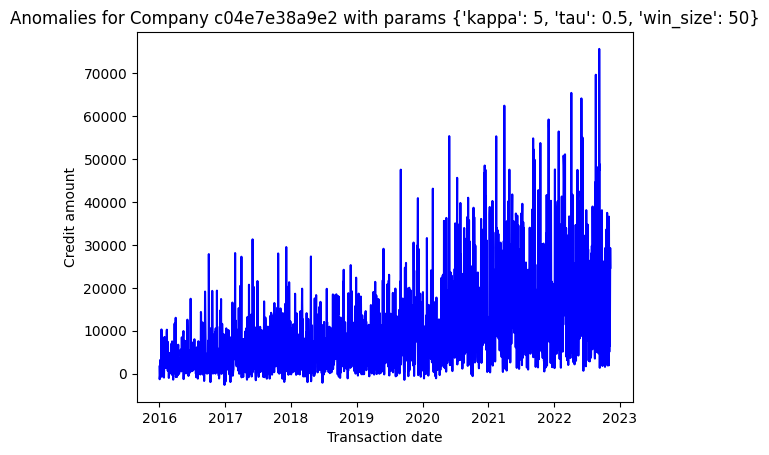

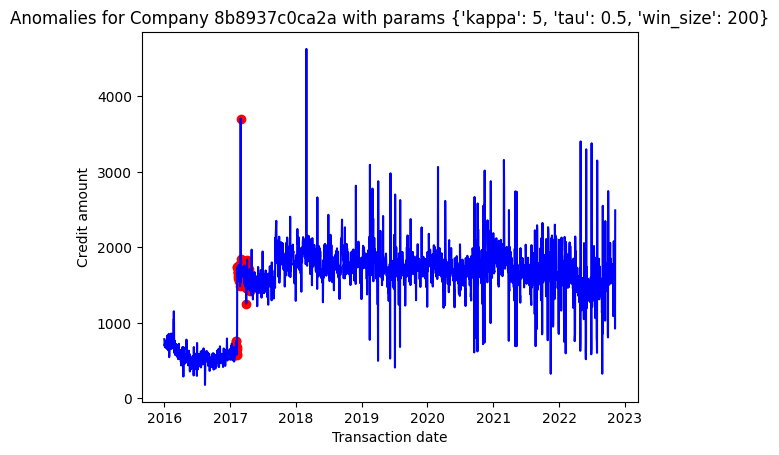

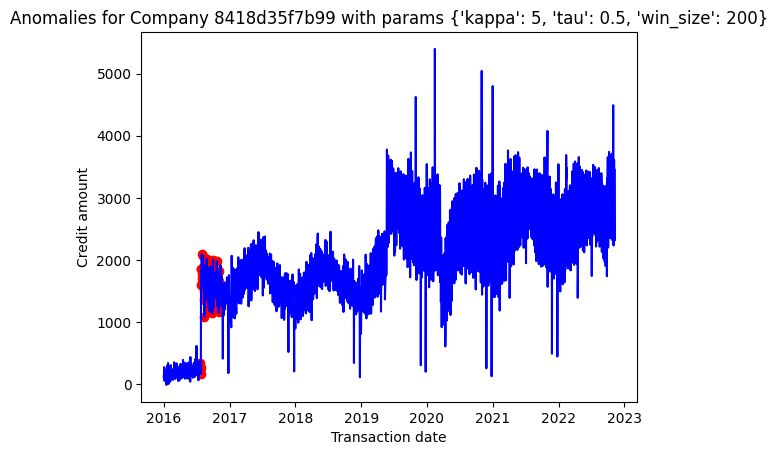

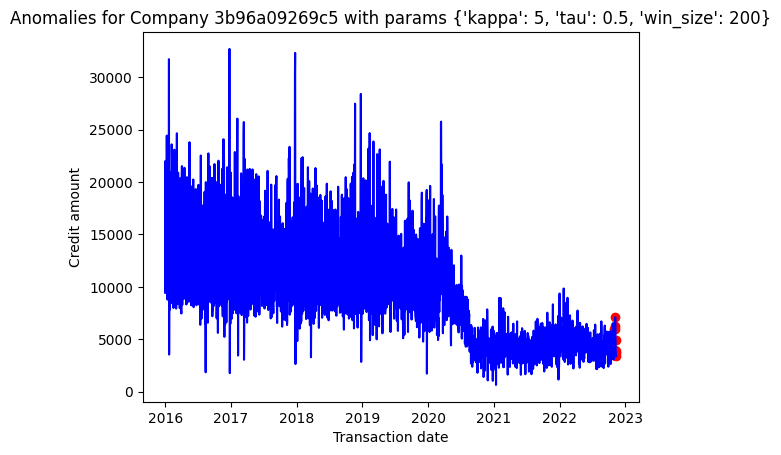

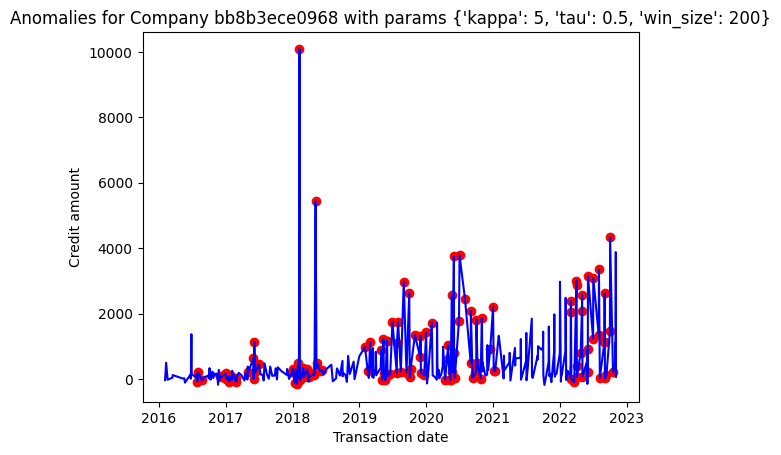

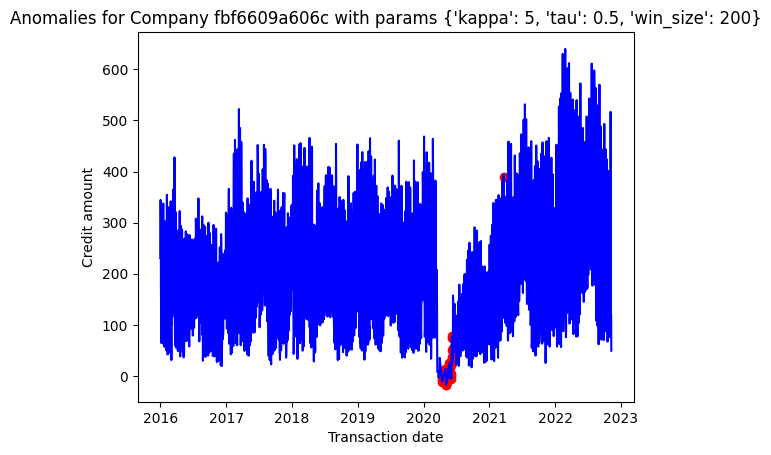

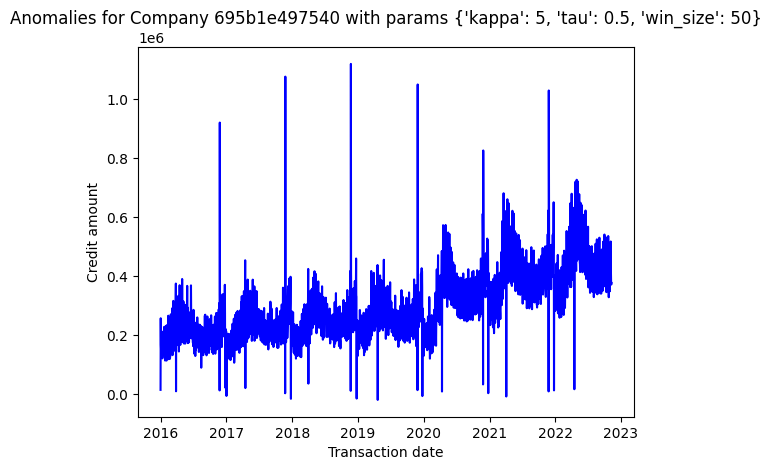

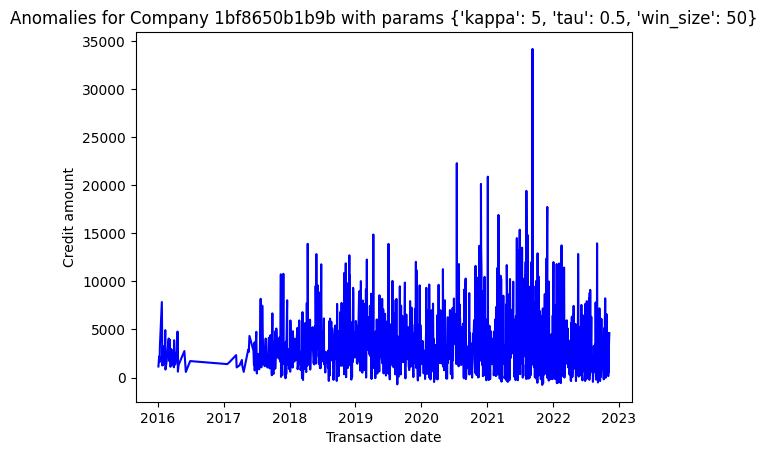

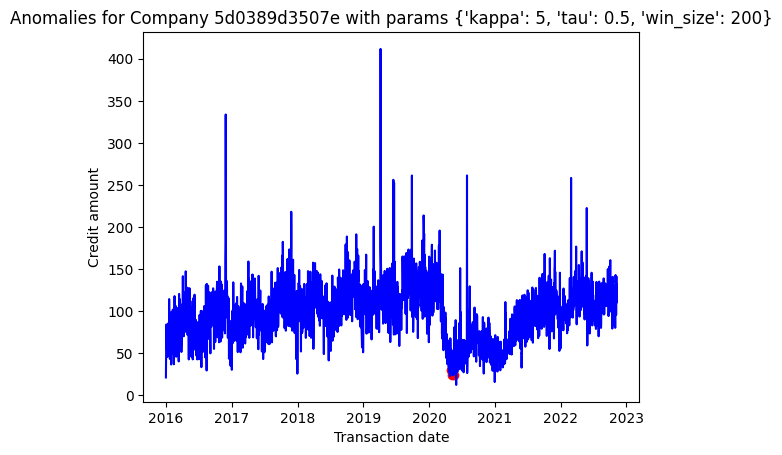

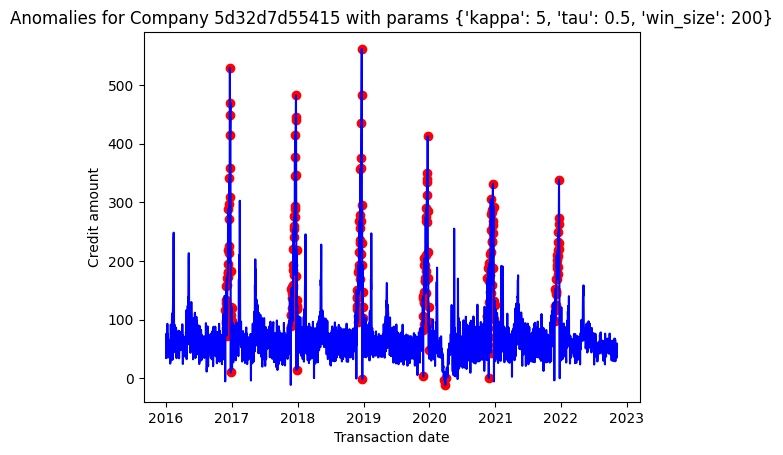

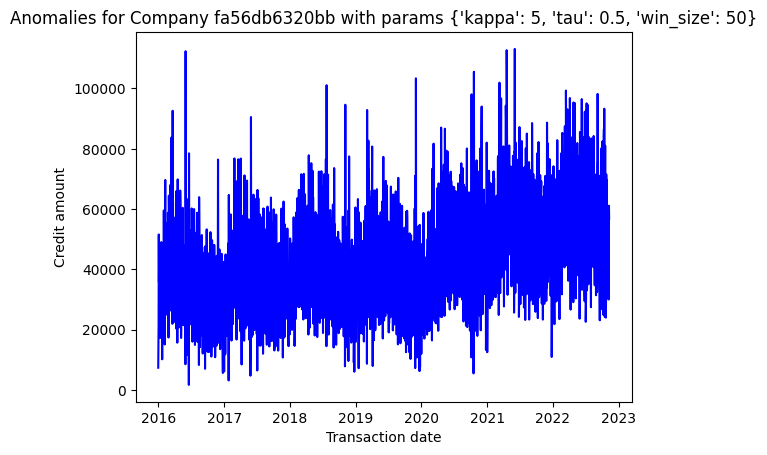

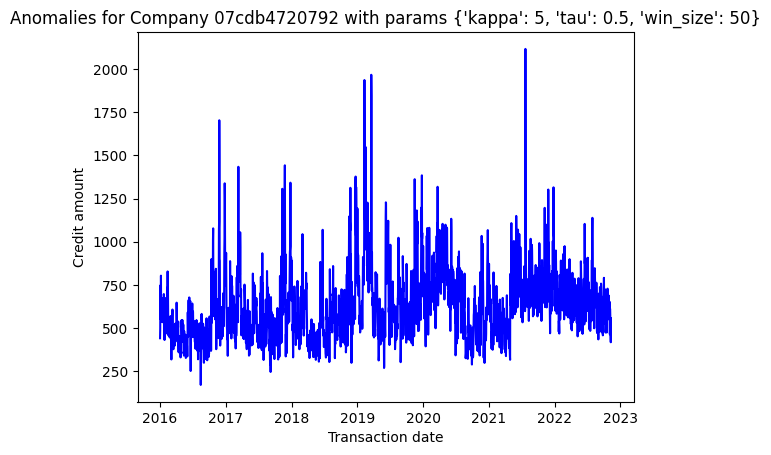

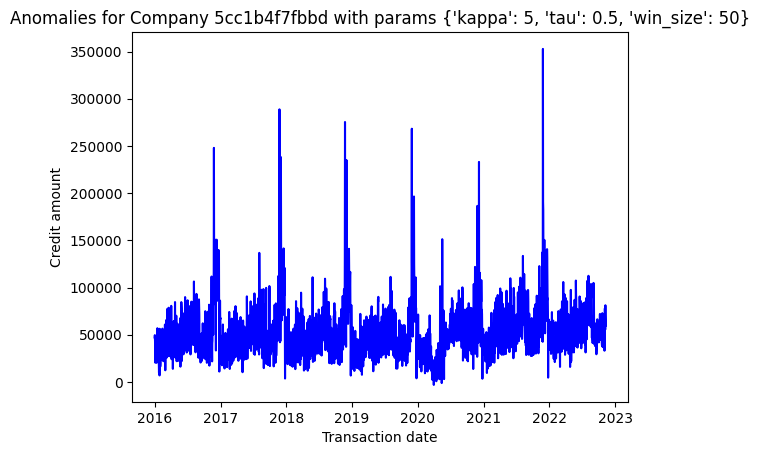

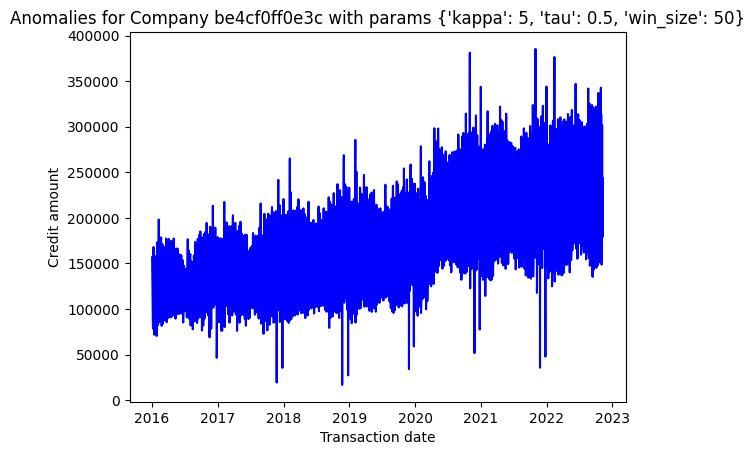

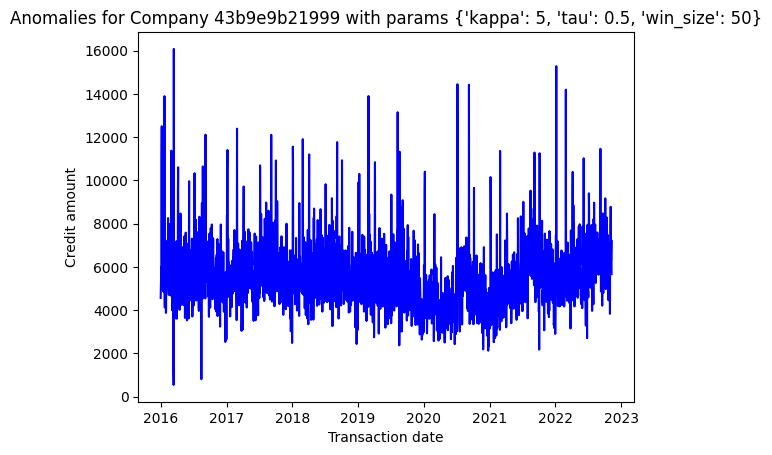

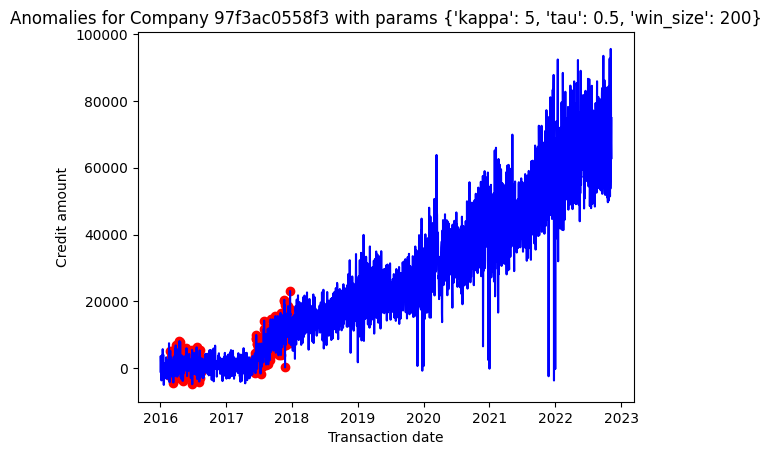

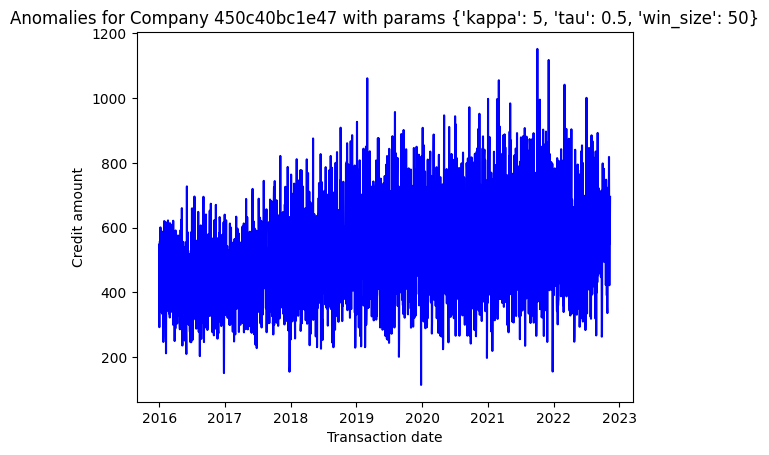

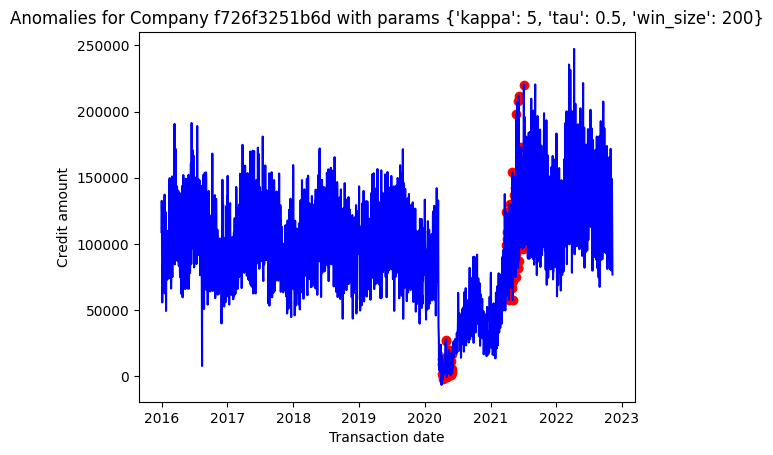

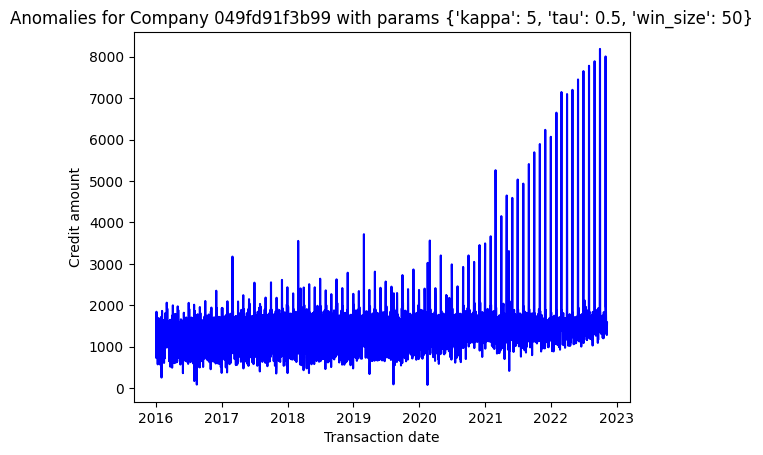

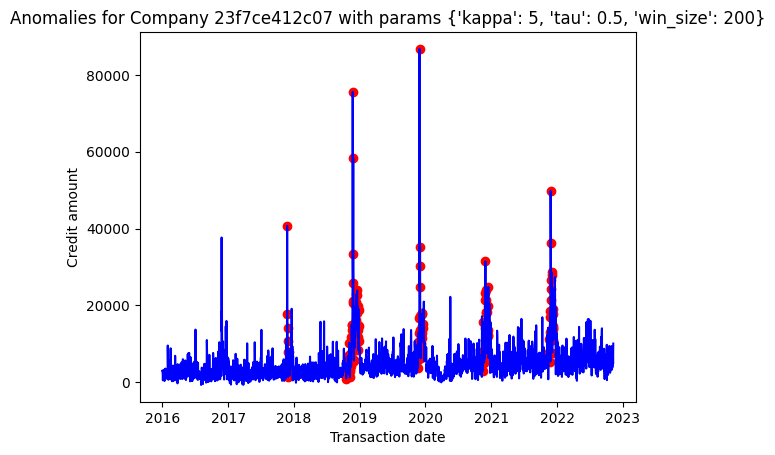

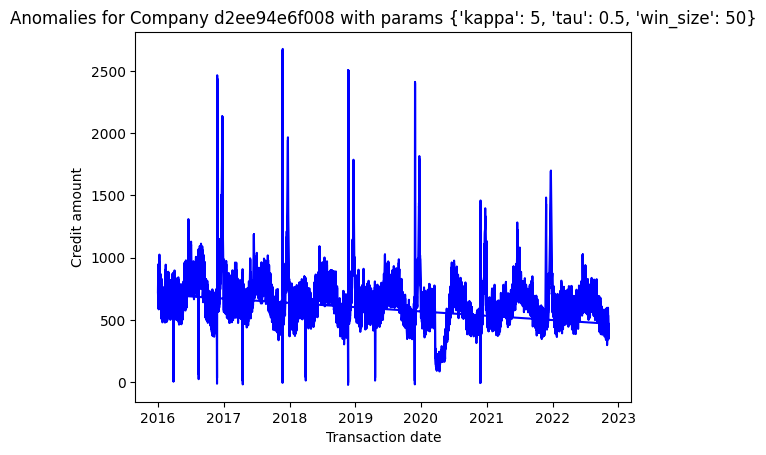

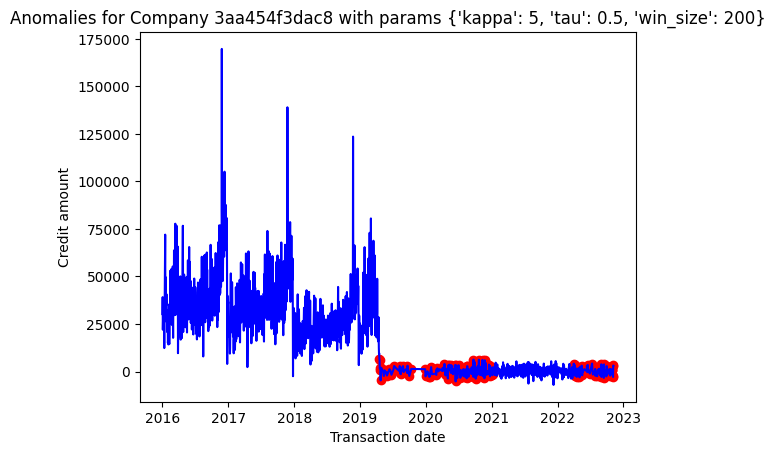

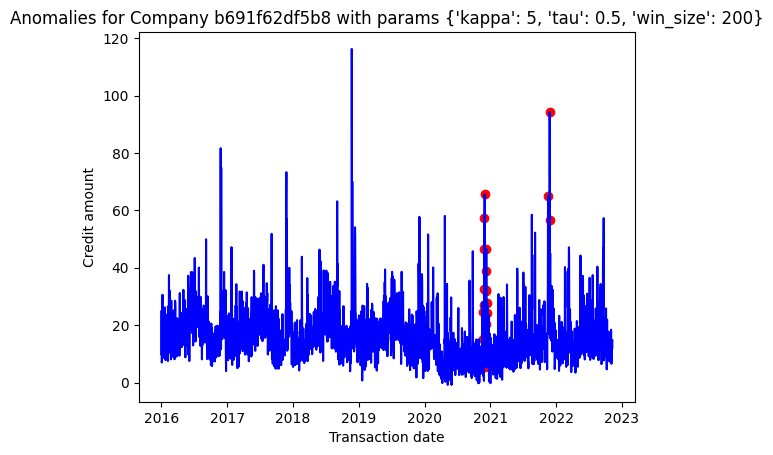

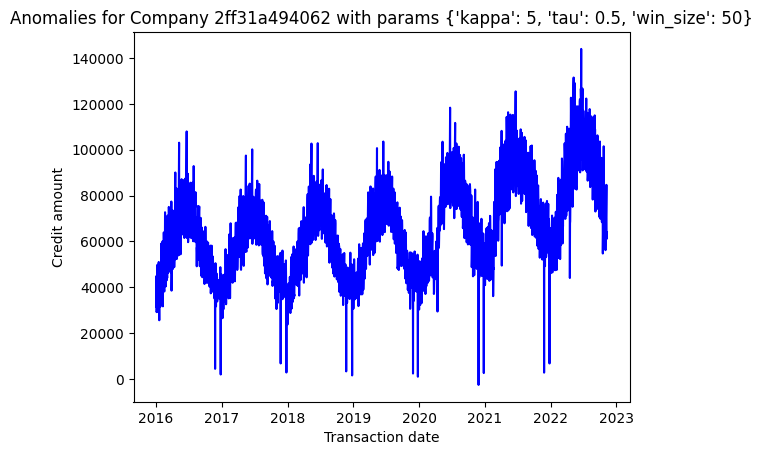

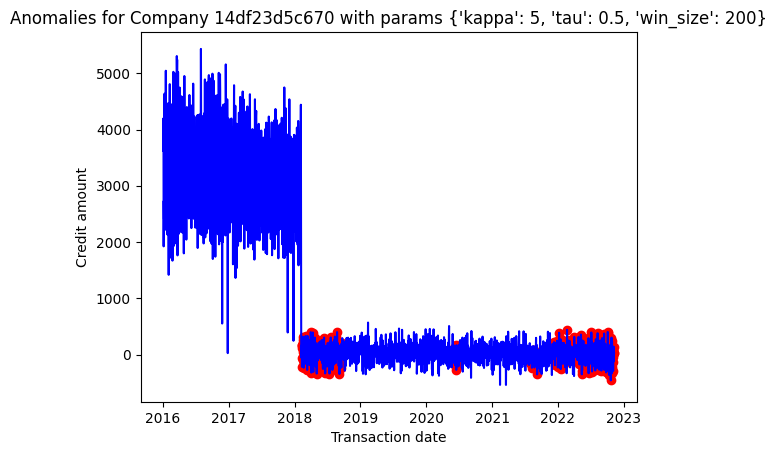

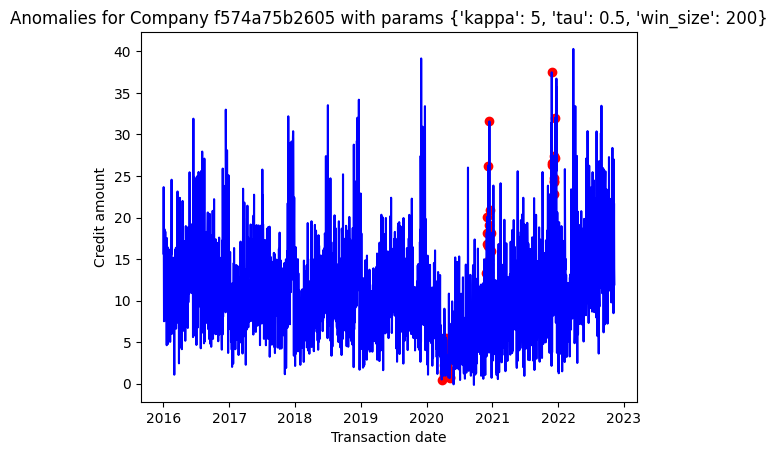

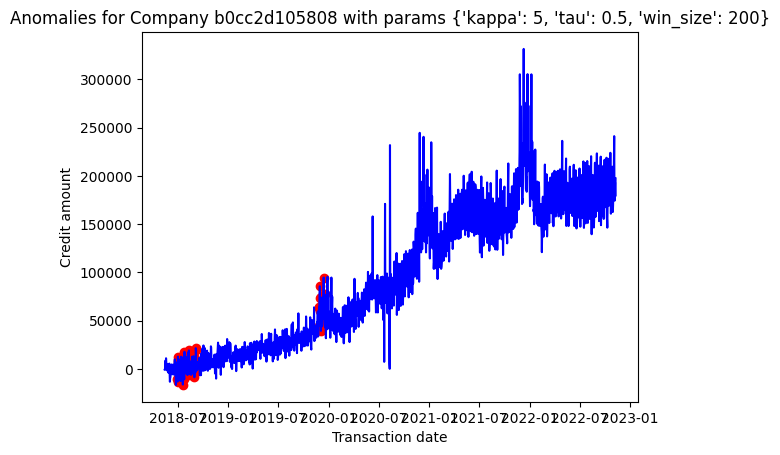

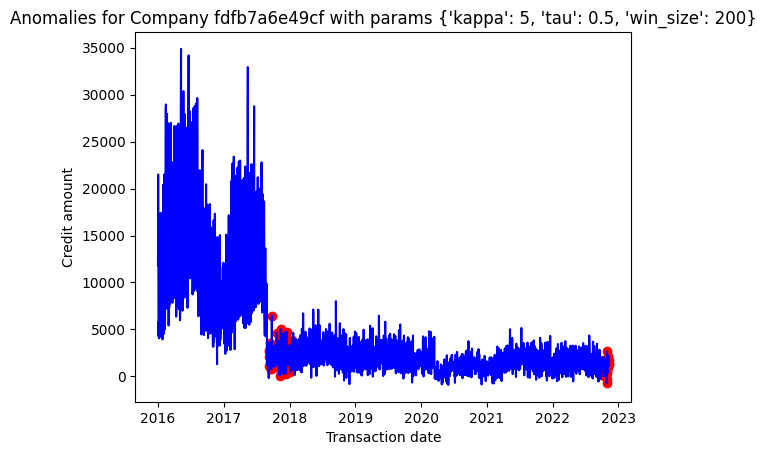

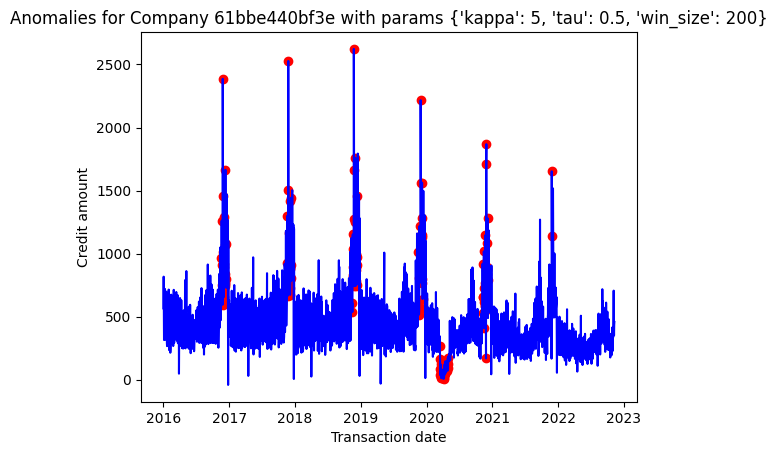

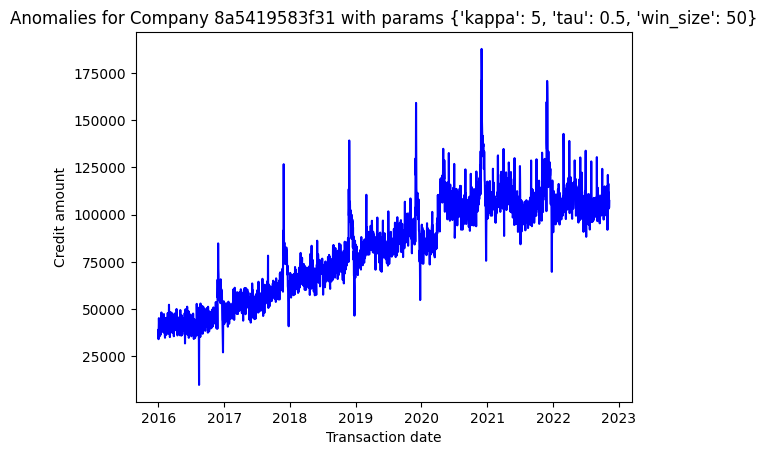

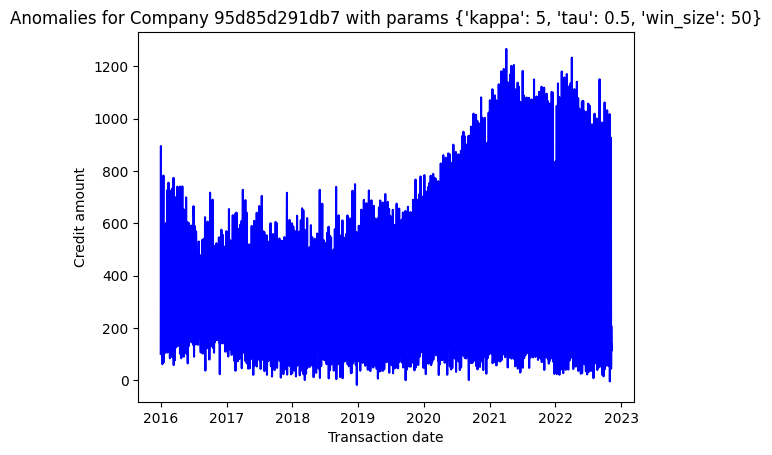

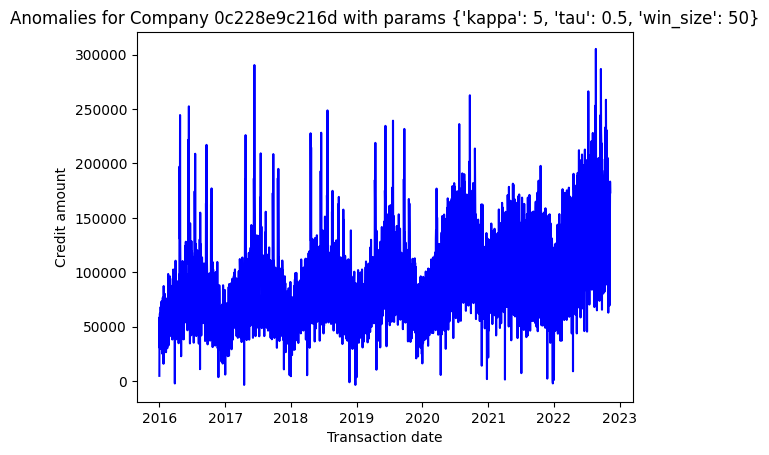

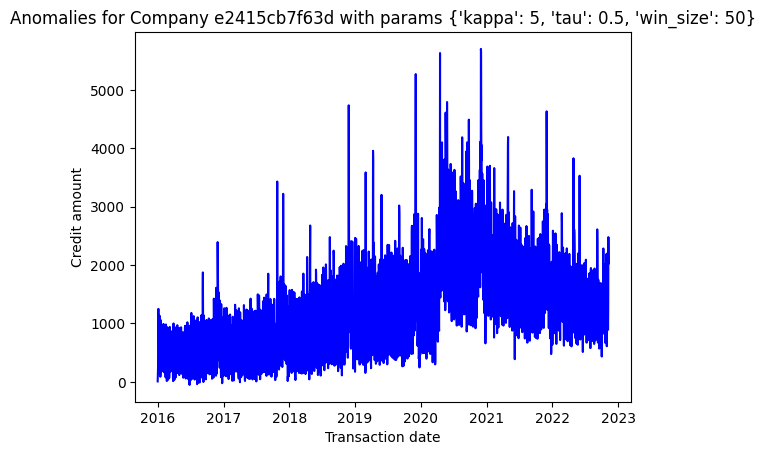

In [ ]:
# Required Libraries in Alphabetical Order
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft, ifft
from scipy.signal import convolve
from sklearn.model_selection import ParameterGrid

class AnomalyDetectionSR:
    def __init__(self, data_path):
        """
        Initialize the AnomalyDetectionSR class with the path to the data.
        Load and preprocess the data.
        """
        # Load the data and convert the 'trans_date' column to datetime format
        self.df = pd.read_csv(data_path)
        self.df['trans_date'] = pd.to_datetime(self.df['trans_date'])
        self.company_ids = self.df['Unnamed: 0'].unique()

    @staticmethod
    def score(anomalies):
        """
        Scoring function for the anomalies.
        """
        return np.sum(anomalies)

    def grid_search(self, sequence, param_grid):
        """
        Perform grid search on the given sequence with the parameter grid.
        """
        best_score = -np.inf
        best_params = None

        # Loop over each combination of parameters
        for params in ParameterGrid(param_grid):
            # Apply spectral residual to the sequence with the current parameters
            anomalies = self.spectral_residual(sequence, **params)
            # Compute the score
            current_score = self.score(anomalies)
            # Update best_score and best_params if current score is better
            if current_score > best_score:
                best_score = current_score
                best_params = params

        return best_params

    @staticmethod
    def spectral_residual(sequence, win_size=100, kappa=10, tau=1.0):
        """
        Implementing the Spectral Residual (SR) algorithm for anomaly detection.
        """
        sequence = np.array(sequence)
        sequence_length = sequence.shape[0]

        # Fourier Transform
        trans = fft(sequence)
        amplitude = np.abs(trans)
        phase = np.angle(trans)

        # Calculate log amplitude and spectral residual
        log_amplitude = np.log1p(amplitude)
        convolve_mat = np.ones(win_size) / win_size
        avg_log_amplitude = convolve(log_amplitude, convolve_mat, 'same')
        spectral_residual = log_amplitude - avg_log_amplitude

        # Inverse Fourier Transform
        saliency_map = np.abs(ifft(np.exp(spectral_residual + 1j * phase)))

        # Anomaly detection
        output_seq = np.zeros(sequence_length)
        for i in range(sequence_length):
            local_avg = np.mean(saliency_map[max(0, i - win_size): i+1])
            if local_avg == 0:
                output_seq[i] = 0
            elif abs((saliency_map[i] - local_avg) / local_avg) > tau:
                output_seq[i] = 1

        return output_seq

    def detect_anomalies(self, param_grid):
        """
        Detect anomalies for each company using the Spectral Residual algorithm.
        """
        for company_id in self.company_ids:
            # Get the sequence for the current company
            sequence = self.df[self.df['Unnamed: 0'] == company_id]['data'].values

            # Use grid search to find the best parameters for the current sequence
            best_params = self.grid_search(sequence, param_grid)

            # Apply spectral residual to the sequence with the best parameters
            anomalies = self.spectral_residual(sequence, **best_params)

            # Plotting
            fig, ax = plt.subplots()
            dates = self.df[self.df['Unnamed: 0'] == company_id]['trans_date']
            ax.plot(dates, sequence, color='blue')
            ax.scatter(dates[anomalies == 1], sequence[anomalies == 1], color='red')
            ax.set_title(f'Anomalies for Company {company_id} with params {best_params}')
            ax.set_xlabel('Transaction date')
            ax.set_ylabel('Credit amount')
            plt.show()

# Note: To load the data, either specify the local path or include the path where it's stored.

data_path = "data4columbia_credit.csv"
adsr = AnomalyDetectionSR(data_path)
param_grid = {
    'win_size': [50, 100, 150, 200],
    'kappa': [5, 10, 15, 20],
     'tau': [0.5, 1.0, 1.5, 2.0]
}
adsr.detect_anomalies(param_grid)